# Ensemble Kalman filter


## 強制振動つきの減衰振り子

$\displaystyle \frac{d^2\phi}{dt^2}=-\left(\frac{2\pi}{T_p}\right)\sin\phi-\gamma\frac{d\phi}{dt}+f\cos\phi\sin\left(\frac{2\pi t}{T_f}\right)$

のような強制振動付きの減衰振り子をオイラー法，あるいは修正オイラー法で解くモデルを考える．

オイラー法は微分方程式
$\displaystyle \frac{dx}{dt}=g(x, t)$
を

$x_{k+1}=x_k+g(x_k, t_k)\Delta t$

のような手続きで解き，修正オイラー法は，

$x_{k+1}=x_k+g\left(x_k+\frac{g(x_k,t_k)\Delta t}{2}, t_k+\frac{\Delta t}{2}\right)\Delta t$

のような手続きで解く．

## 双子実験

データ同化のテストとしてよく行われるのが「双子実験」である．双子実験とは，
1. 数値モデルを実行し，さらに観測も模擬することで擬似的な観測データを生成する．
1. 初期値などを変えた同じモデルに，擬似観測データを同化し，データ同化がうまく行くかを検証する．

という手順で，データ同化の有効性を確認する実験のことである．

以下では，全く同じモデルへの同化と，精度の劣るモデル(オイラー法)の2種類のモデルへの同化を行う．

In [43]:
import numpy as np
import numpy.random as ran
import matplotlib.pylab as plt

Ndim = 2 # 状態 x の次元
Nobs = 1 # 観測 y の次元
dt = 0.2 # 時間刻み
Tmax = 1200 # 全時間ステップ
robs = 0.01 # 観測誤差の標準偏差
obs_tinterval = 30 # 観測の時間間隔

Tperiod = 30.0
Tforce = 70.0
gamma = 0.01
forcing = 0.03


class Pendulum_state:
  def __init__(self, Tlag = 0):
    self.x = np.zeros(( Tlag + 1, Ndim ))


class Pendulum_model:
  def __init__(self, dt):
    self.dt = dt
    self.a = (2.0*np.pi / Tperiod)**2
    self.g = gamma
    self.f = forcing
    self.omf = 2.0*np.pi / Tforce

## Euler法で解く
  def Euler(self, xst, t):
    Tlen = xst.x.shape[0]
    g0 = np.zeros((Ndim))

    g0[0] = xst.x[0,1]
    g0[1] = - self.a*np.sin(xst.x[0,0]) - self.g*xst.x[0,1] + self.f*np.sin(self.omf*t)*np.cos(xst.x[0,0])

    for k in range(Tlen-1, 0, -1):
      xst.x[k,:] = xst.x[k-1,:]

    xst.x[0,:] += self.dt * g0

## 修正Euler法で解く
  def modifiedEuler(self, xst, t):
    Tlen = xst.x.shape[0]
    g0 = np.zeros((Ndim))
    g1 = np.zeros((Ndim))

    g0[0] = xst.x[0,1]
    g0[1] = - self.a*np.sin(xst.x[0,0]) - self.g*xst.x[0,1] + self.f*np.sin(self.omf*t)*np.cos(xst.x[0,0])

    xt = xst.x[0,:] + self.dt * g0 / 2
    tt = t + self.dt / 2

    g1[0] = xt[1]
    g1[1] = - self.a*np.sin(xt[0]) - self.g*xt[1] + self.f*np.sin(self.omf*tt)*np.cos(xt[0])

    for k in range(Tlen-1, 0, -1):
      xst.x[k,:] = xst.x[k-1,:]

    xst.x[0,:] += self.dt * g1

In [44]:
# 観測の設定
class Pendulum_observation:
  def __init__(self, rsig):
    rarr = rsig*rsig*np.ones(( Nobs ))
    self.Rmat = np.diag( rarr )
    self.Rsqrt = np.diag( np.sqrt(rarr) )
    self.Rinv = np.diag( 1.0 / rarr )
    self.Hmat = np.zeros((Nobs, Ndim))
    for i in range(Nobs):
      self.Hmat[i,i] = 1.0

  def hobs(self, xst):
    yob = self.Hmat.dot(xst.x[0,:])
    return yob

  def obs_perturbation(self):
    return self.Rsqrt.dot(ran.randn(Nobs))

In [45]:
## State vector
xstate = Pendulum_state( Tmax )

## Pendulum model
xsys = Pendulum_model( dt )

## For synthetic observation
obsm = Pendulum_observation( robs )

## Initialization
xstate.x[0,0] = 0.2
xstate.x[0,1] = 0.3

truefile = open( "true.dat", 'w' )
obsfile = open( "obs.dat", 'w' )
truefile.write("{0:6}{1:12.6f}{2:12.6f}\n".format(0, xstate.x[0,0], xstate.x[0,1]))

ran.seed(seed=100)

## 擬似データの生成
for k in range(1,Tmax+1):
  xsys.modifiedEuler( xstate, k*dt )

  if k % obs_tinterval == 0:
    yobs = obsm.hobs( xstate ) + obsm.obs_perturbation()
    obsfile.write( "{0:6} ".format(k*dt) )
    for i in range(Nobs-1):
      obsfile.write( "{0:15.6f} ".format(yobs[i]) )
    obsfile.write( "{0:15.6f}\n".format(yobs[Nobs-1]) )

  truefile.write("{0:6}{1:12.6f}{2:12.6f}\n".format(k*dt, xstate.x[0,0], xstate.x[0,1]))

truefile.close()
obsfile.close()

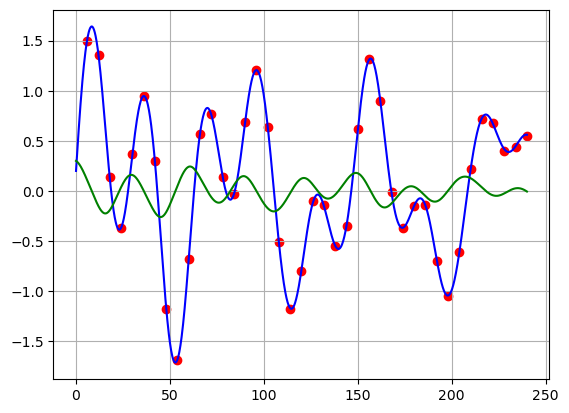

In [46]:
## Plot
xarr = np.loadtxt("true.dat")
yarr = np.loadtxt("obs.dat")
plt.plot( xarr[:,0], xarr[:,1], color='b' )
plt.plot( xarr[:,0], xarr[:,2], color='g' )
plt.scatter( yarr[:,0], yarr[:,1], color='r' )##红点是模拟观测数据
plt.grid()
plt.show()

## 非線型状態空間モデル
$\boldsymbol{x}_k=\boldsymbol{f}_k(\boldsymbol{x}_{k-1})+\boldsymbol{v}_k$,  
$\boldsymbol{y}_k=\mathsf{H}_k\boldsymbol{x}_k+\boldsymbol{w}_k$.

## アンサンブルカルマンフィルタ
+ 予測:  
各アンサンブルメンバー$i$に対して  
$\boldsymbol{v}_k^{(i)}\sim \mathcal{N}(\boldsymbol{0}, \mathsf{Q})$,  
$\boldsymbol{x}_{k|k-1}^{(i)}=\boldsymbol{f}_k(\boldsymbol{x}_{k-1|k-1}^{(i)})+\boldsymbol{v}_k^{(i)}$.


+ フィルタ  
$\displaystyle \hat{\boldsymbol{x}}_{k|k-1}=\frac{1}{N}\sum _{i=1}^N \boldsymbol{x}_{k|k-1}^{(i)}$,$\quad$
$\displaystyle \hat{\mathsf{P}}_{k|k-1}=\frac{1}{N-1}\sum _{i=1}^N \left(\boldsymbol{x}_{k|k-1}^{(i)}-\hat{\boldsymbol{x}}_{k|k-1}\right)\left(\boldsymbol{x}_{k|k-1}^{(i)}-\hat{\boldsymbol{x}}_{k|k-1}\right)^T$,  
$\hat{\mathsf{K}}_k=\hat{\mathsf{P}}_{k|k-1}\mathsf{H}_k(\mathsf{H}_k\hat{\mathsf{P}}_{k|k-1}\mathsf{H}_k^T+\mathsf{R}_k)^{-1}$,  
$\boldsymbol{x}_{k|k}^{(i)}=\boldsymbol{x}_{k|k-1}^{(i)}+\hat{\mathsf{K}}_k(\boldsymbol{y}_k-\mathsf{H}_k\boldsymbol{x}_k^{(i)}+\boldsymbol{w}_k^{(i)})$.  

$\hat{\mathsf{P}}_{k|k-1}$は，$\boldsymbol{1}=(1\quad \cdots \quad 1)^T$として，  
$\displaystyle \mathsf{E}_{k|k-1}=\left(\boldsymbol{x}_{k|k-1}^{(1)}\quad\cdots\quad \boldsymbol{x}_{k|k-1}^{(N)}\right)$,$\quad$
$\displaystyle \mathsf{A}=\mathsf{I}-\frac{1}{N}\boldsymbol{1}\boldsymbol{1}^T$  
とおくと  
$\displaystyle \mathsf{E}_{k|k-1}\mathsf{A}=\left(\boldsymbol{x}_{k|k-1}^{(1)}-\hat{\boldsymbol{x}}_{k|k-1}\quad\cdots\quad \boldsymbol{x}_{k|k-1}^{(N)}-\hat{\boldsymbol{x}}_{k|k-1}\right)$,$\quad$
$\displaystyle \hat{\mathsf{P}}_{k|k-1}=\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T$  
のように書ける．$\mathsf{Y}_{k|k-1}=\mathsf{H}_{k}\mathsf{E}_{k|k-1}\mathsf{A}$とおくと，$\mathsf{A}\mathsf{A}^T=\mathsf{A}\mathsf{A}=\mathsf{A}$に注意すれば，
  $\displaystyle \hat{\mathsf{K}}_k=\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T\mathsf{H}_k\left(\frac{1}{N-1}\mathsf{H}_k\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T\mathsf{H}_k^T+\mathsf{R}_k\right)^{-1}
  =\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{Y}_{k|k-1}^T\left(\frac{1}{N-1}\mathsf{Y}_{k|k-1}\mathsf{Y}_{k|k-1}^T+\mathsf{R}_k\right)^{-1}$,  
のようにして$\hat{\mathsf{K}}_k$を得ることもできる．


In [47]:
import copy

class Filter(object):
  def __init__( self, xens, sysmodel, obsmodel ):
    self.nptcls = len(xens)
    self.sym = sysmodel
    self.obm = obsmodel
    weq = 1.0 / self.nptcls
    self.weight = np.full((self.nptcls), weq)

  def prediction(self, xens, t):
    for i in range(self.nptcls):
      self.sym.Euler( xens[i], t )
      self.sym.modifiedEuler( xens[i], t )

  def enkf(self, xens, ydata):
    Ymat = np.zeros((Nobs, self.nptcls))
    for i in range(self.nptcls):
      Ymat[:,i] = self.obm.hobs(xens[i])

    ymean = np.reshape(np.mean(Ymat, 1), (Nobs,1))
    DY = Ymat - ymean
    YYmat = DY.dot(DY.T)/(self.nptcls - 1.0) + self.obm.Rmat

    Yinov = np.reshape(ydata, (Nobs,1)) - Ymat
    for i in range(self.nptcls):
      Yinov[:,i] += self.obm.obs_perturbation()
    Wmat = (DY.T).dot((np.linalg.inv(YYmat)).dot(Yinov)) / (self.nptcls - 1.0)

    xorg = copy.deepcopy( xens )
    for i in range(self.nptcls):
      for j in range(self.nptcls):
        xens[i].x += Wmat[j,i] * xorg[j].x


  def estimation(self, xens, Tlag = 0):
    xensmean = Pendulum_state( Tlag )
    xensvar = Pendulum_state( Tlag )

    for i in range(self.nptcls):
      xensmean.x += self.weight[i] * xens[i].x
      xensvar.x += self.weight[i] * xens[i].x**2
    xensvar.x = xensvar.x - xensmean.x**2

    return xensmean,xensvar

In [48]:
Npt = 80 # Ensemble size
q = 0.001 # Standard deviation of system noise
r = 0.1 # Standard deviation of observation noise
Tlag = 0 # Filter
#Tlag = 60 # For smoother

ran.seed(seed=100) # Seed

xp = [None] * Npt
for i in range(Npt):
  xp[i] = Pendulum_state( Tlag )
  xp[i].x[0,0] = ran.normal( 0.0, 1.0 )
  xp[i].x[0,1] = ran.normal( 0.0, 0.2 )

xsysm = Pendulum_model( dt )
obmodel = Pendulum_observation( r )
filt = Filter( xp, xsysm, obmodel )

yobs = np.loadtxt("obs.dat")
xest = np.zeros((Tmax+1, Ndim))

qmean = np.zeros((Ndim))
Qmat = q*q*np.eye(Ndim)

## EnKF loop
xmean,xvar = filt.estimation( xp, Tlag )
xest[0,:] = xmean.x[0,:]

for k in range(1,Tmax+1):
  filt.prediction( xp, k*dt )
  for i in range(Npt):
    xp[i].x[0,:] += ran.multivariate_normal( qmean, Qmat )

  if k % obs_tinterval == 0:
    j = int(k / obs_tinterval) - 1
    filt.enkf( xp, yobs[j,1:] )

  xmean,xvar = filt.estimation( xp, Tlag )

#  Fixed lag smoother
  if k >= Tlag:
    xest[k-Tlag,:] = xmean.x[Tlag,:]
    
  if np.isnan(np.sum(xest[k,:])):
    print(k)
    break
## EnKF loop end

for k in range(Tlag):
  xest[Tmax-k,:] = xmean.x[k,:]

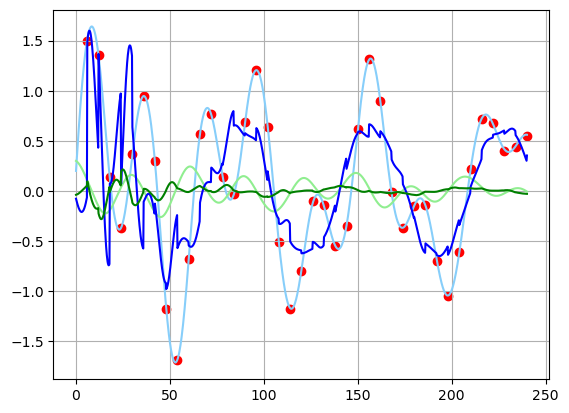

In [49]:
## Plot
xtruth = np.loadtxt( "true.dat",)
plt.plot( xtruth[:,0], xtruth[:,1], color='LightSkyBlue' )
plt.plot( xtruth[:,0], xtruth[:,2], color='LightGreen' )

plt.plot( xtruth[:,0], xest[:,0], color='b' )
plt.plot( xtruth[:,0], xest[:,1], color='g' )

plt.scatter( yobs[:,0], yobs[:,1], color='r' )
plt.grid()
plt.show()